# GEOCLASS Tutorial 

# Background on the GEOCLASS Cyber-Infrastructure

GEOCLASS-Image is a cyber-infrastructure (CI) developed by the Geomathematics, Remote Sensing, and Cryospheric Sciences Laboratory at the University of Colorado Boulder for the classification of high-resolution satellite imagery. This CI was specifically designed for applications in the cyrosphere as there is a lack of labeled image based datasets which limits the effectiveness of machine learning (ML). The main bennifits from this CI include the creation of a dataset over a specified region, the ability to label datasets through an inuitive graphical user interface (GUI), training of three neural networks that each take a different type of data as input, ResNet18, VarioMLP, and VarioNet, the modification of these networks if desired, the classification of all images in a dataset through ML, user controlled settings for the creation and saving of large scale datasets. While this software was designed for applications in the cryosphere, any GEOTiff image could be used as input, expanding the possible applications of the CI.

# Installing Packages and Libraries

Before the user can install the CI, python 3.x, pip and git must installed on your machine. These should be installed on your machine by default. To check your version of python/pip and upgrade if necessary, follow [this guide for Ubuntu](https://phoenixnap.com/kb/how-to-install-python-3-ubuntu) or [this guide for MacOS](https://opensource.com/article/19/5/python-3-default-mac). For git, follow [this guide](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git). Once these have been installed/upgraded 
Start by going to the [GEOCLASS GitHub](https://github.com/Herzfeld-Lab/GEOCLASS-image) and installing all the files in the main branch or running this command 
```
git clone https://github.com/Herzfeld-Lab/GEOCLASS-image.git
```

# Configuration
Within the primary project directory, there are 3 main sub-directories that the user will interact with. First, the `Config` directory, which contains configuration parameters for the classification model, training algorithm and dataset. Second is the `Data` directory, which contains the GeoTIFF images which comprise a dataset. Lastly, the `Output` directory contains output from the training, testing and visualization scripts in the form of model checkpoints, classification results and figures.
## Setting up the Data Folder
Each GeoTIFF image dataset should have its own sub-directory in `Data`. This directory should contain one or more GeoTIFF-formatted images that all contain data from the same [UTM Zone](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system). For the example project followed in this guide, a `Data/Negri_WV` directory was created, which contains 5 GeoTIFF images of the Negribreen Glacier taken by the WorldView-1 and WorldView-2 satellites.
## Setting up the Config Folder
Each individual classification project should have its own sub-directory in `Config`. At a minimum, this directory should contain:
1. A YAML-formatted `.config` file which defines all necessary parameters and filepaths for the classification task (described in detail below)
2. A `.npy`-formatted 'contour' file containing a list of UTM coordinates which define the boundaries of the area-of-interest for the classification task.

There is an example Config folder with the above files included in `Config/mlp_test_negri`, which contains the configuration for classifying surface types of the Negribreen Glacier from WorldView GeoTIFF images. The easiest way to set up your own project is to copy this folder, and change the necessary parameters. In order to create your own area-of-interest contour file, skip to the [Generating a Contour File](#generating-a-contour-file) section before proceeding with the rest of this tutorial.
### Setting up the Image Folder
In order to train a network directly from images, the training image folder needs to be set up correctly. Inside this folder should be be a folder for each class, labeled with the class number, that you want to train the network on. In each class' folder the images need to be labeled in the following manner. The first digits of the image should be the class that it is associated with. The last digit in the image's name is the WV image from the dataset it was taken from.While this is only needed for training VarioMLP, this should be set to zero if there are no WV images associated with the image. If you are not using outside images, this process is automated during the [labeling](#labeling-training-data) proccess.
## Config Parameters
The YAML-formatted `.config` file contains all of the configuration parameters for a classification task. To create your own config file, simply copy the example provided in `Config/mlp_test_negri/mlp_test_negri.config` and change the parameters to fit your task. The config file must have the exact format provided in the example file for the NN_Class software to work. The parameters in the config file are split into 5 categories, which are defined as follows:
### Model Parameters
The model parameters define the hyperparameters of the classification model. Some of these parameters are only relevant to the provided VarioMLP model, implemented in `Models/VarioMLP.py`. For the other provided Resnet18 model (implemented in `Models/Resnet18.py`), set these parameters to `None`.
- `model`: This defines which Neural Network model to be used. The example project uses VarioMLP.
- `num_classes`: The number of classes for the classification task.
- `vario_num_lag`: (VarioMLP-only) The number of lag values to be used in the directional Variogram.
- `hidden_layers`: (VarioMLP-only) The shape of the hidden layers of the VarioMLP network. Detailed description provided [here](#variomlp).
- `activations`: The activation functions used in the neural network's hidden layers (right now, only [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) is supported).
### Dataset Parameters
The dataset parameters define the filepaths and hyperparameters pertaining to the 'split image' dataset. When starting a new project, the `img_path`, `class_enum`, `utm_epsg_code`, `split_img_size`, `train_test_split`, `training_img_path` parameters should be defined. The variables `save_all_pred` and `equal_dataset` are booleans for controlling how predictions will be saved. The `npy_path` and `training_img_npy` parameters will be automatically filled in when [creating a dataset](#creating-a-dataset).
- `img_path`:         The path to the directory containing the GeoTIFF images in your dataset (explained [here](#setting-up-the-data-folder)).
- `npy_path`:         The filepath to the .npy file containing all the split image data (explained [here](#creating-a-dataset)).
- `train_path`:       The npy file for model created predictions used to visualize results in the `hist.py` and `confMatrix` programs.
- `valid_path`:       The npy file for user labeled images/validation dataset used to visualize results in the `hist.py` and `confMatrix` programs.
- `class_enum`:       A list of human-readable class names, of length `num_classes`.
- `utm_epsg_code`:    [EPSG code](https://epsg.io/) of the UTM zone the geotiff image is within.
- `split_img_size`:   Desired size of split images, in pixels.
- `train_test_split`: Percentage of images to be kept as training images (0.8 == 80%), the rest are used for testing.
- `triain_indices`  :     Whenever a new file is used for training, set this to None. When the training program is run this will be updated with a .npy file for tracking what indices were used for training and what was used for testing so one can ensure that all models are trained with the same validation dataset. 
- `training_img_path`:    The path to directory containing folders of images to use for training.
- `training_img_npy`:     The path to the .npy file created from the folder of images.
- `save_all_pred`:      Boolean for saving predictions from all WV images in a dataset.
- `equal_dataset`:      Boolean for saving a prediction with equal number of images in every class.
### Training Parameters
The training parameters govern how the classification model is trained when using `train.py`. The [Training](#training) section contains a detailed description of these operations.
- `train_with_img`:     If true, the model will be trained wither from the image .npy or the folder of images depending on the model.
- `use_cuda`:       If true, utilizes GPU for training and testing. See [Using a GPU](#using-a-gpu)
- `num_epochs`:     Maximum number of epochs to run the training loop
- `fine_epochs`:    (VarioNet-only) Maximum number of epochs to run the fine tuning loop of VarioNet
- `adaptive`:     (VarioNet-only) If true the alpha and beta variables will be automatically determined and tuned based on the confidence of ResNet18 while training VarioNet
- `alpha`:    (VarioNet-only) Weight out of one for VarioMLP while training VarioNet
- `beta`:      (VarioNet-only) Weight out of one for Resnet18 while training VarioNet
- `learning_rate`:  Initial learning rate for the optimizer
- `batch_size`:     Number of split images to be passed through network before each iteration of the backpropagation
- `optimizer`:      Optimization algorithm to be used during training (right now, only [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is supported)
### Data Augmentation Parameters
The data augmentation parameters define the preprocessing steps performed on the training data before being run through the classification model. An introduction to the motivations behind data augmentation and some basic techniques can be found [here](https://markku.ai/post/data-augmentation/).
- `directional_vario`:    Whether to use directional variogram on split images (Always true for VarioMLP model)
- `random_rotate`:        Randomly rotate via variogram before feeding into network
- `random_shift`:         Randomly shift area to perform variogram over (if the split images are not squares)
- `random_contrast`:      Randomly adjust contrast (untested)
- `random_distort`:       Depracated
### Visualization Parameters
The visualization parameters define how training labels and classification results are visualized when using the Split Image Explorer GUI.
- `contour_path`:     Filepath to list of UTM coordinates of contour (described [here](#setting-up-the-config-data-folder))
- `custom_color_map`: List of desired class color [hex codes](https://www.color-hex.com/) of length `num_classes`. If not specified, the matplotlib [tab20](https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html) color map will be used.
- `bg_img_path`:      Filepath to background image to display visualizations over (depracated, scaled tiff image used instead)
- `bg_img_utm`:       Filepath to list of UTM coordinates of background image (depracated)

# Creating Your First Dataset

## Ensuring the Config File is Properly Setup

Once all the nessisary packages, libraries, and files are downloaded you are ready to start using the GEOCLASS CI. As shown below, the first step of GEOCLASS is the creation of a dataset. 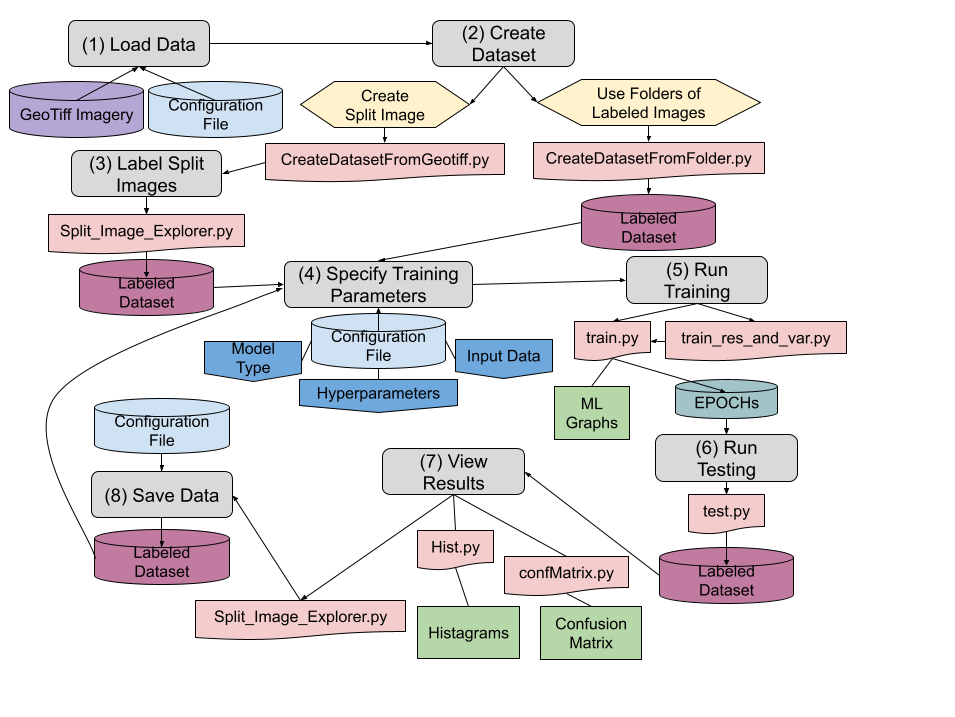 

To create this dataset first make a [Data Folder](#setting-up-the-config-folder) and store all the high-resultion GeoTiffs that you want for your dataset in this folder. For the example images used in this walkthrough five GeoTiffs from the WorldView1 and WorldView2 satellites were added to this folder. Next open the configuration file and modify the following parameters: `num_classes`, `img_path`, `contour_path`, `class_enum`, `utm_epsg_code`, and `split_img_size`. Ensure that `img_path` is the path to the Data Folder that was just created, the number of classes in `class_enum` relates to the number specified in `num_classes` and that the `utm_espg_code` is correct. Lastly ensure that `contour_path` is the path to a file that overlies the desired region of intrest (ROI). If you do not already have a contour file for your desired ROI this can be set to None and created later through the split image explorer. 

## Creating the Dataset

The  `createDatasetFromGeotiff.py` script is used to create a Dataset from source GeoTIFF images. It takes as an argument the filepath to your `.config` file, and produces a `.npy` file in the same directory containing the split image data for the entire dataset.
```
python3 createDatasetFromGeotiff.py Config/mlp_negri_legacy/mlp_test_negri.config
```
In general the output file will be named as `{your-config-filename}_{number-of-split-images}_{split-image-size}.npy`. When checking the `.config` file, you will see the `npy_path` parameter has been filled with this filepath.

# Labeling Training Data

The first step in any classification task is to gather labeled training data. The Split Image Explorer GUI tool provides an intuitive interface for labeling split images based on the classes defined by the `num_classes` and `class_enum` parameters in the config file. These labeled images will be saved under `training_img_path` to analyze the split images without running the GUI. To run the GUI, simply run `Split_Image_Explorer.py` with the config file as an argument, just as `createDatasetFromGeotiff.py` was run:
```
python3 Split_Image_Explorer.py Config/mlp_negri_legacy/mlp_test_negri.config
```
After a short loading process, you will be presented with a GUI window like this:
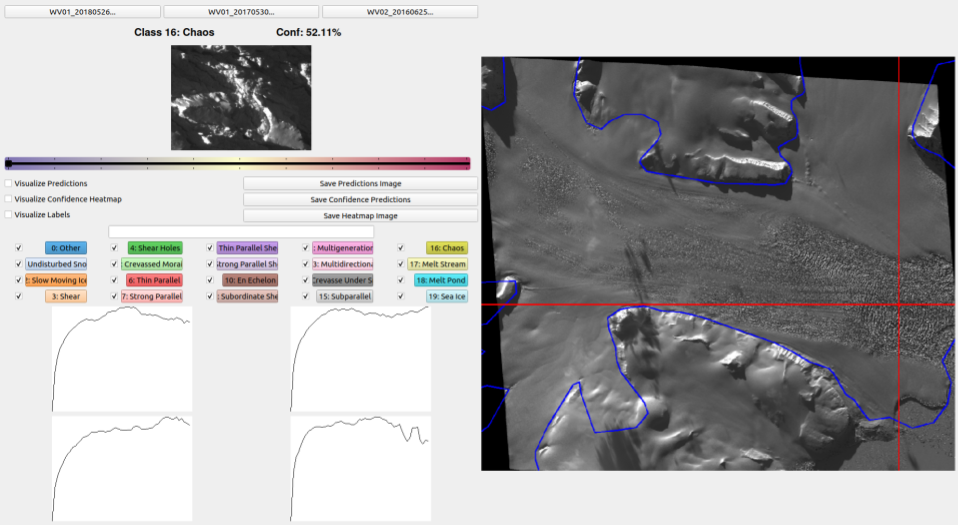

The GUI provides many useful tools for labeling and viewing split images, and understanding classification results. To start, try clicking around the geotiff image preview on the right half of the GUI, within the contour shown in blue. This allows for selecting any split image from the source geotiff based on the location of the crosshairs. Here is a breakdown of each of the components present in the GUI (each of these will be explored in detail in their respective sections):
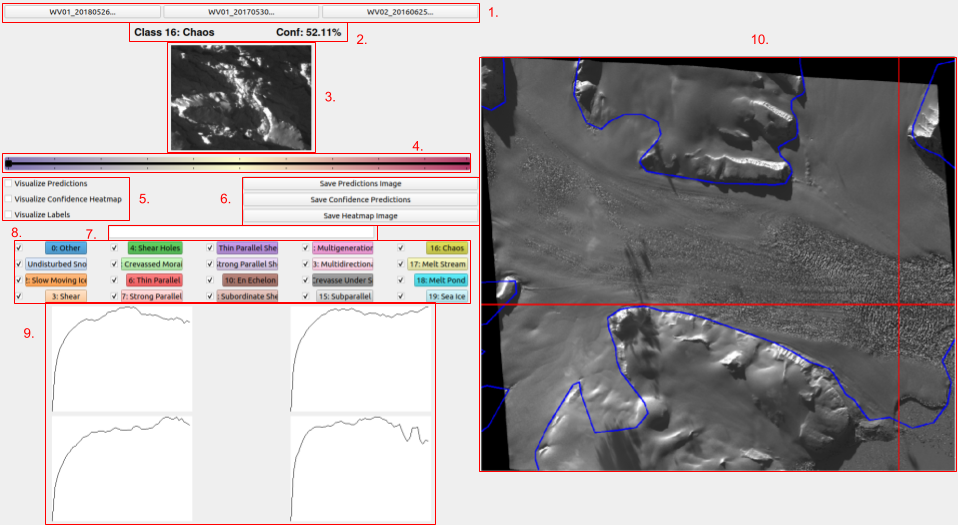

1. Source GeoTIFF selector buttons. These buttons can be used to switch between source geotiff images for visualization/labeling split images.
2. This text will display the label of the current split image, or the classification and confidence if the model has been trained.
3. Split Image preview. This window shows the split image at the current location of the crosshairs in the geotiff preview window.
4. Confidence Slider. This slider can be used to set a confidence threshold for visualizing classifications.
5. Visualization toggles. These toggles can be used to switch between visualizing training labels, classification labels, or classification confidence values in the geotiff preview window.
6. Output buttons. These buttons can be used to save the predications as a .npy file and save images of the classification or confidence values.
7. New Class field. If a new class is needed, type its name in this field and press enter. The config class buttons, toggles and config file will be updated automatically.
8. Class buttons. These buttons can be used to label the current split image, or batch label all split images within the currently defined polygon. The check boxes to the left of each class allows you to toggle on or off this class when viewing the labeled or predicted classes.
9. Variograms. These area of the GUI shows the calculated variograms for the currently selected image
10. Geotiff preview window. This shows a scaled-down preview of the currently selected source geotiff image, with the user-defined UTM contour drawn in blue. The crosshairs show the location of the currently selected split image.
### Individual Labeling
To explore the split images in the Dataset, move the crosshairs by either clicking a location within the blue contour, or using the 'a' and 'd' keys to move to split images adjacent to the currently selected split image. To label the currently selected split image, either click on one of the colored class buttons in the bottom left of the GUI, or press its corresponding number key on your keyboard. To view your labels, toggle the 'Visualize labels' toggle in the left of the GUI. For example, after pressing d-0-d-0-d-0-d-0-d-0-d-0... on the keyboard, then toggling the Visualize Labels toggle, the result looks like this:
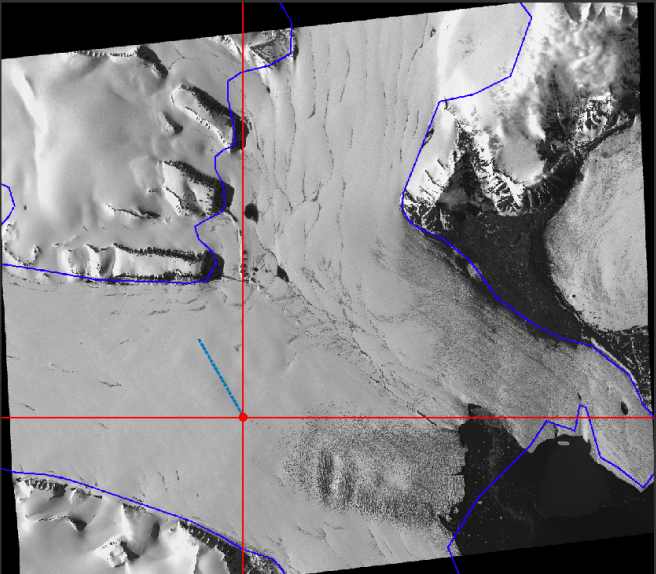
### Batch Labeling
Most of the time, split images that are near each other in the source GeoTIFF image will be classified similarly. In order to label a batch of split images together, the user can define an arbitrary polygon in the GeoTIFF preview window by right clicking to choose its vertices. Then, the class buttons or number keys can be used to label all split images that fit within the polygon in the same was they are used to label individual images. In the example project, after selecting and labeling two arbitrary polygons and toggling the Visualize Labels toggle, this was the result:
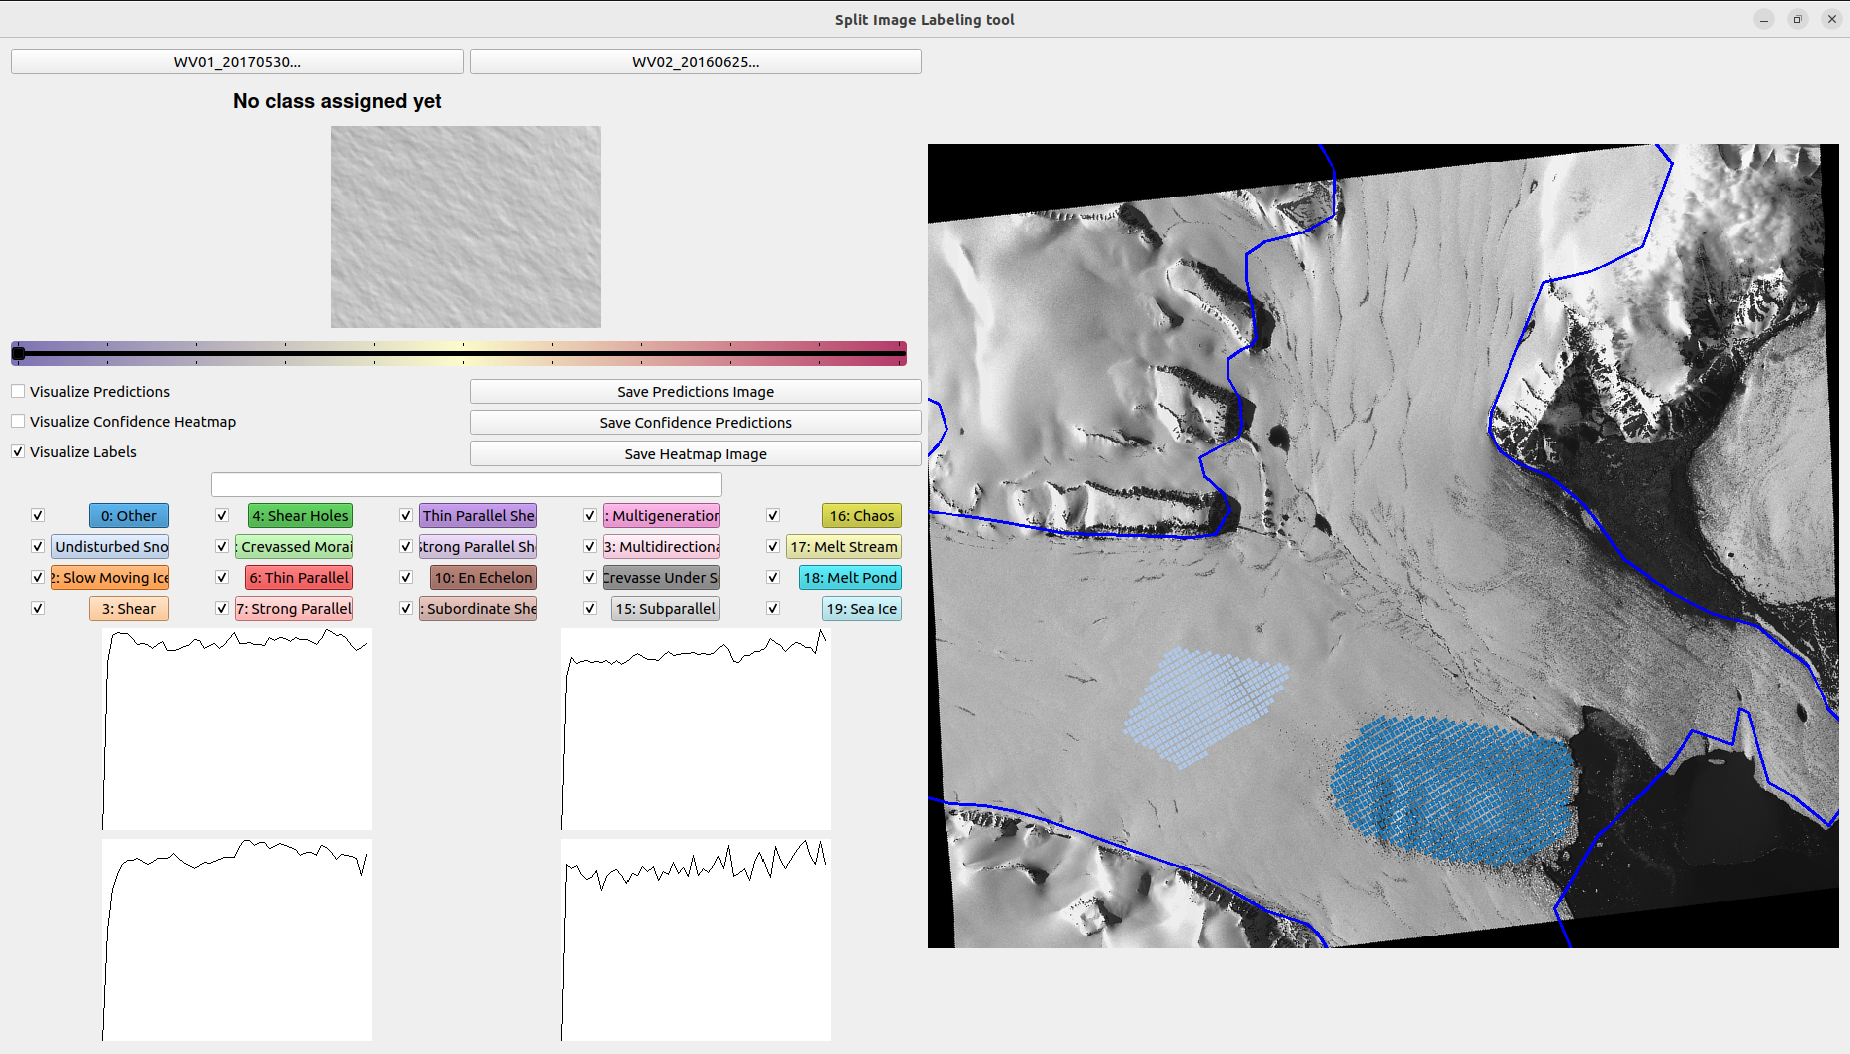
To switch to a different source GeoTIFF image, the Source GeoTIFF selector buttons in the top left of the GUI can be used. To add more training images to our example project, the 4th GeoTIFF image was selected and the batch labeling process repeated:
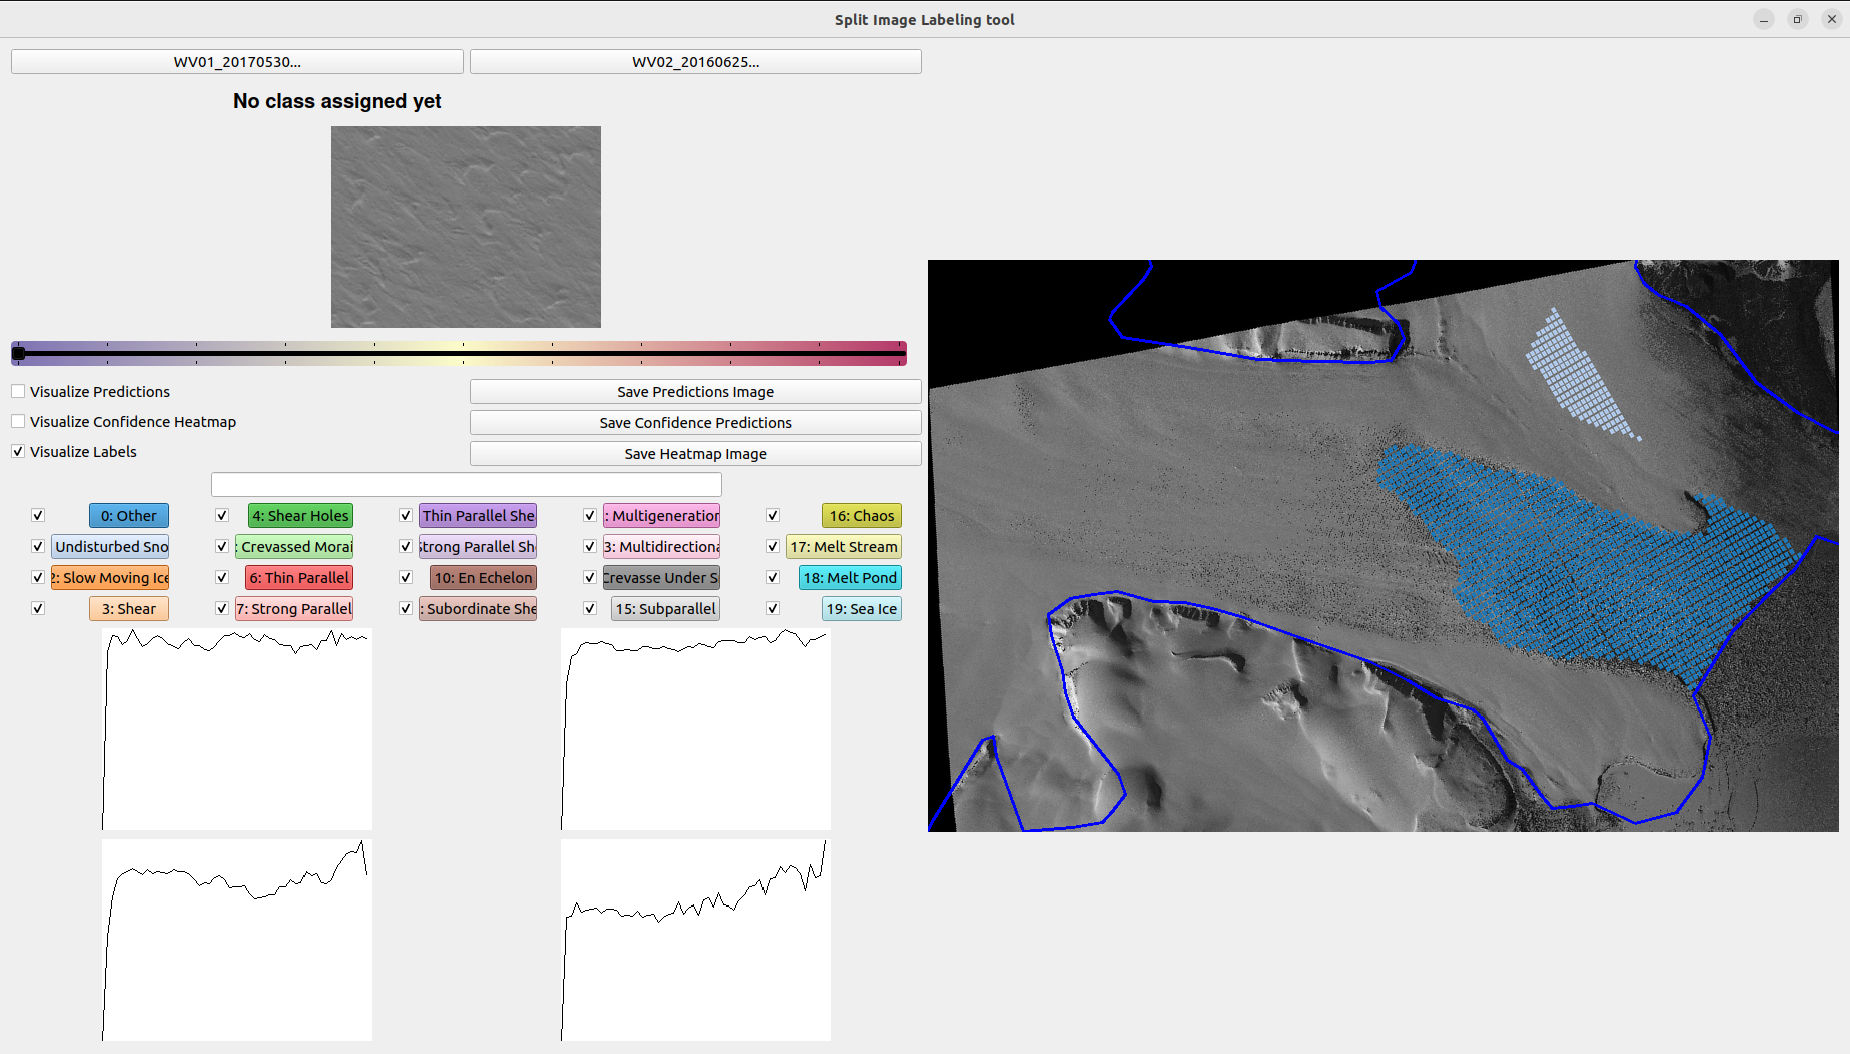

**NOTE:** When the Split Image Explorer tool loads, it will automatically rotate the geotiff image preview to orient north/south, as well as zoom into the intersection of the contour and the source geotiff. If you do not have a UTM-coordinate contour file for your classification task, you can create one using the Split Image Explorer tool. This process is outlined in the [Generating a Contour File](#generating-a-contour-file) section.
### Visualizing Labels
As demonstrated above, the 'Visualize Labels' toggle can be used to view the training labels created by individual or batch labeling. It is important to note that if additional labels are created while the Visualize Labels toggle is on, it will need to be toggled off and on again to view the new labels. Additionally, the class toggles in the lower left of the GUI can be used to view only one (or a subset) of the classes at a time. One could also utilize the directory from the `training_img_path` to visualize all the images by class. If using the directory of images, one can delete images from the classification folder simply by deleting it. If the user uses the .npy file for training there is no way to unclassify images, one can only switch the image's class once its been labeled.
### Dataset Output
Upon exiting the GUI, any labels created will be automatically saved to the [Dataset file created above](#creating-a-dataset). All images will also be automatically saved to the `training_img_path` directory.

# Training

When training the user can chose to simply use the .npy dataset that was created and labeled above or they can use a directory of images if the user wishes to include images that are not part of the dataset they [created](#setting-up-the-image-folder). After the input data has been chosen through the modification of the `train_with_img` parameter in the Config file, the user can then select the ML model they wish to train. There are currently three models availible through the GEOCLASS CI, ResNet18, VarioMLP and VarioNet, which can be changed through the modification of the `model` parameter in the Config file. ResNet18 is a convolutional neural network known for its effectivness in image classification that is purely data-driven. VarioMLP is a multi-layer perceptron (MLP) that uses a variograms as input making it a physically driven network. [Variograms](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/variogram) are a geostatistical calculation that can give insight on spatial patterns when applied to an image. VarioNet is a combined MLP that takes the un-normalized outputs, called logits, from VarioMLP and ResNet18, combines them, and passes them through the layers in VarioNet. While VarioNet is a MLP, its architecture was built to resemble that of ResNet18 and the number of blocks, size of each layer, and use of downsampling/identity mapping can be modified inside the VarioNet.py file. 

## Training ResNet18

In order to train ResNet18 the user must edit some variables in the Config file besides the traing path (`npy_path` or `train_with_img`). The user must modify the following variables:

- `activations`: The activation functions used in the neural network's hidden layers (right now, only [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) is supported).
- `train_test_split`: This variable can range from 0-1 and represents the amount of images that will be used for training versus validation. A value of 0.75 would mean 75% the images in the dataset will be used for training and the other 25% is used for validation. 
- `train_indices`: The first time you train any model this will be set to `None`. Once the training program is run, autimatically a file with the naming convention: `{your-config-filename}_{number-of-classes}_{number-of-training-images}.npy`. This file represents which images from the dataset are used for training and what are used for validation and ensures that the user is always using the same exact dataset when desired.
- `use_cuda`:       If true, utilizes GPU for training and testing. See [Using a GPU](#using-a-gpu)
- `num_epochs`:     The amount of times the dataset will be passed through one cycle of training
- `learning_rate`:  Initial learning rate for the optimizer
- `batch_size`:     Number of images to be passed through network before each iteration of the backpropagation
- `optimizer`:      Optimization algorithm to be used during training (right now, only [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is supported)

Once these are all accurate, run `train.py` with your config file as the single argument, in the same way as `Split_Image_Explorer.py` and `createDatasetFromGeotiff.py`. For the example case the command was:
```
python3 train.py Config/mlp_negri_legacy/mlp_test_negri.config
```

## Training VarioMLP

For the training of VarioMLP must ensure that all the variable used for ResNet18 are accurate, then modify the following variables:

- `vario_num_lag`: The distance between pixel values used for the calculations of the variogram. If using an image where the sides are porportionally 3-4 the num lag is set and the user must calculate this by first multiplying either side by the lag threshold (defult value is 0.8 but this can be changed in the utils file) then dividing it by its porportion (if you are using the longer side divide by 4, shorter side divide by 3).
- `hidden_layers`: The shape of the hidden layers of the VarioMLP network. Detailed description provided [here](#variomlp)
- `directional_vario`:    Whether to use directional variogram on split images (Always true for VarioMLP model)
- `random_rotate`:        Randomly rotate via variogram before feeding into network
- `random_shift`:         Randomly shift area to perform variogram over (if the split images are not squares)

Once these are all accurate, run `train.py` with your config file as the single argument, in the same way as `Split_Image_Explorer.py` and `createDatasetFromGeotiff.py`. For the example case the command was:
```
python3 train.py Config/mlp_negri_legacy/mlp_test_negri.config
```

## Training VarioNet

In order to train VarioNet the user must first train ResNet18 and VarioMLP and save the model to load up later when training. This allows for ResNet18 and VarioMLP to be pre-trained on the same image data so they don't need to be retrained each time VarioNet is run. Once all the variable noted above are correct run `train_res_and_var.py` like `train.py` with the config file as the single argument like:
```
python3 train_res_and_var.py Config/mlp_negri_legacy/mlp_test_negri.config
```
Once this program has run you will notice two new files in the working directory `resnet18.pth` and `vario_mlp.pth`. Do not rename these files unless you go into `train.py` and change the path of the ResNet18 and VarioMLP models that are loaded into the program. Before one trains VarioNet there are some additional variables in the Config file that need to be changed. The user must ensure the following variables are correct before training:

- `fine_epochs`:    Maximum number of epochs to run the fine tuning loop of VarioNet. The fine tuning loop decreases the learning rate to fine tun weights of each layer in VarioNet.
- `adaptive`:     If true the alpha and beta variables will be automatically determined and tuned based on the confidence of ResNet18 while training VarioNet
- `alpha`:    Weight ranging from 0-1 for VarioMLP while training VarioNet
- `beta`:      Weight ranging from 0-1 for Resnet18 while training VarioNet where `alpha` + `beta` = 1 

If these variables are set up and there is ResNet18 and VarioMLP paths in the working directory, the user can train the full VarioNet network through the same code as the other two networks by running `train.py` in the way explained above. 

## Output from Training

Once a network is trained, a folder is created under the `Output` directory. In this directory, you will find the folder created from the training by the following naming conventions: . `{name-of-your-config-file}_{time-and-date-of-training-run}`. The user should not change the name of this folder and should store runs into seperate, labeled subdirectory. Within each output subdirectory, 3 subdirectories titled checkpoints/, labels/ and losses/ will be generated. The checkpoints/ subdirectory will contain all saved model checkpoints from the training script. By default, the training script will save a model checkpoint at the end of each epoch if and only if the validation loss is better than the previous best validation loss. For more information on the significance of loss values when training a classification model, see this guide. The model checkpoint files generated for the training run above look like this:

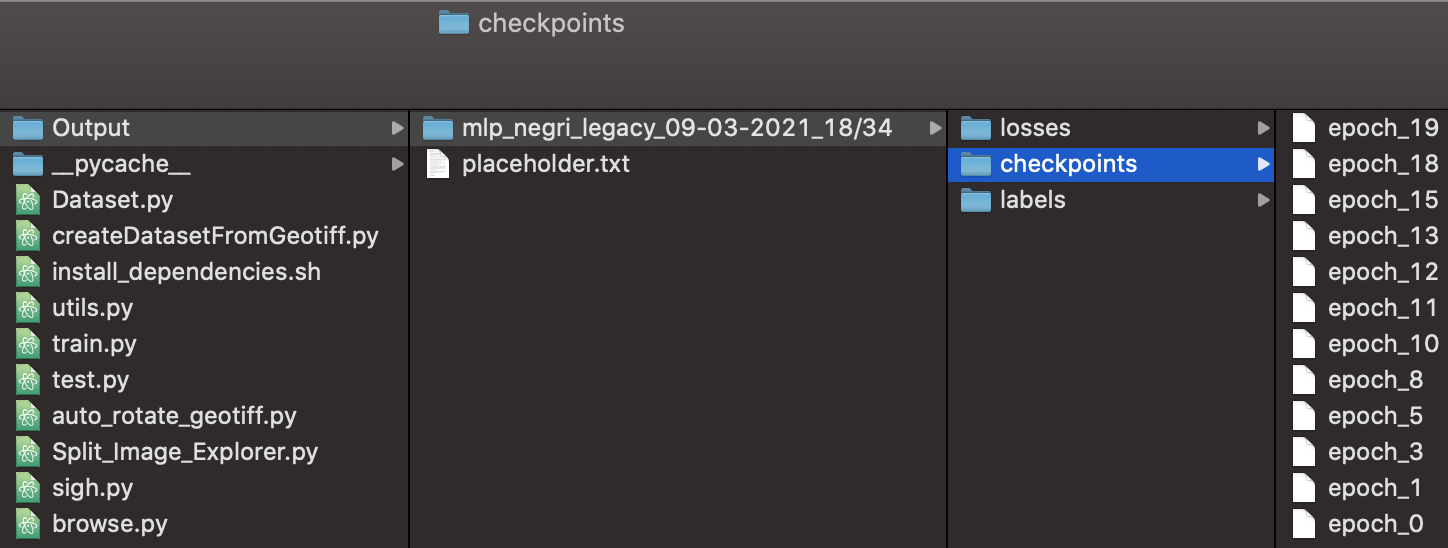

The training script will also output a .npy file containing the training and validation loss for each epoch, as well as a training/validation loss graph located in the losses/ subdirectory. The loss graph for the above training run (stored in Output/mlp_negri_legacy_09-03-2021_18:34/losses/) looks like this:

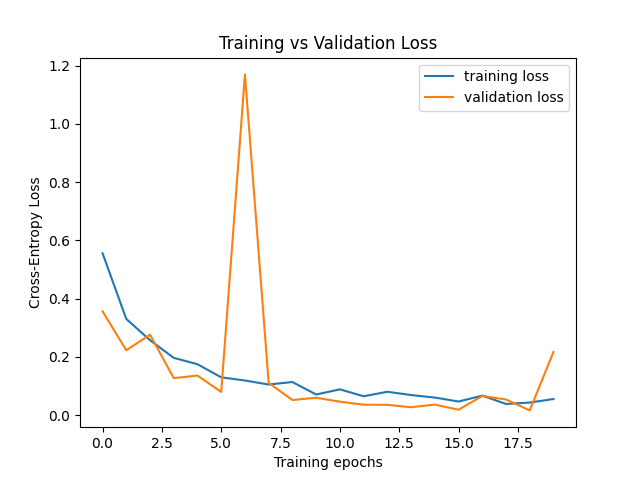


## Training Options

The training script supports the ability to load and resume training from a previously defined model checkpoint. To do this, run `train.py` with the additional command-line flag `--load_checkpoint`. In the case of the example training run above, to restart training from the epoch 11 checkpoint the command would be:
```
python3 train.py Config/mlp_negri_legacy/mlp_test_negri.config --load_checkpoint Output/mlp_negri_legacy_09-03-2021_18:34/checkpoints/epoch_11
```

There are also numerous hyperparameters related to training in the config file. For a description of the available training hyperparameters please refer to the [Training Parameters](#training-parameters) section.

# Testing

After looking at the losses from the training run and selecting a desired model checkpoint, the `test.py` script can be used to label all split images in the dataset using the trained classification model. `test.py` takes two arguments: the config file as the first argument (same as all the other scripts), and the `--load_checkpoint` argument to specify a model checkpoint. For the example run, using the epoch 11 model checkpoint, the command was:
```
python3 test.py Config/mlp_negri_legacy/mlp_test_negri.config --load_checkpoint Output/mlp_negri_legacy_09-03-2021_18:34/checkpoints/epoch_11
```
The labeling process will take quite a while for cases in which the dataset consists of multiple large source GeoTIFF images. Labeling all 41,310 split images in the example case took about 10 minutes.

## Testing Output

After running the test script, a `.npy` file containing the classification labels for all split images in the dataset will be generated in the `labels` subdirectory of the output subdirectory. For the test run above, a file called `Output/mlp_negri_legacy_09-03-2021_18:34/labels/labelled_epoch_11.npy` was generated:
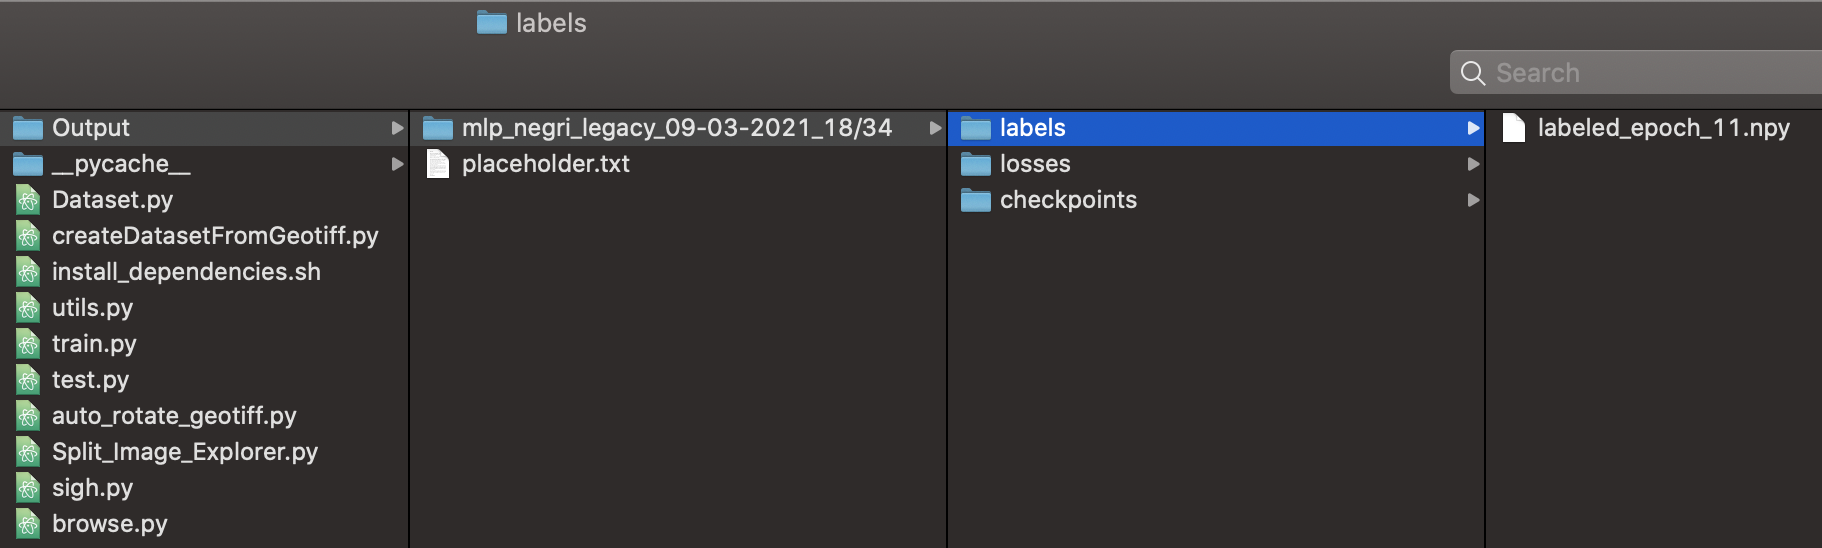

Along with this, if the user decides to use adaptive weights while testing VarioNet a subdirectory `plots` will be created inside the output subdirectory. This subdirectory will contain a plot showing what weights were used for ResNet18 and how confident VarioNet was for that weight. These plots allow the user to gain insight on how confident ResNet18 was for each image, and how the reliance of ResNet18 effects the confidence of VarioNet. An example of one of these plots can be seen below:

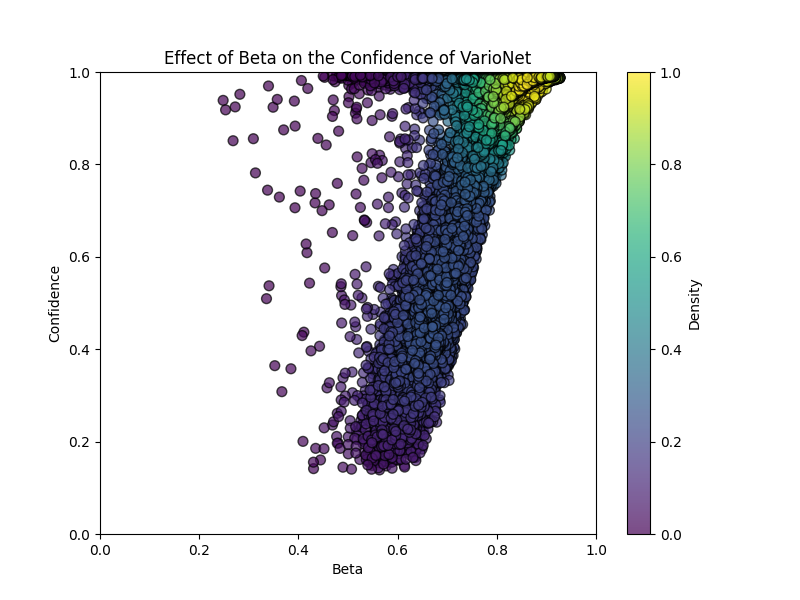

# Visualizing

## GUI Visualization

Through the use of the GUI the user can get visualize the results from the testing program using the labels `.npy` file. To load the GUI with the labels, run `Split_Image_Explorer.py` with the config file as an argument followed by `--load_labels` then the path to the labeled file. To view the file created from the testing output above, the following code was run:
```
python3 Split_Image_Explorer.py Config/mlp_negri_legacy/mlp_test_negri.config --load_labels Output/mlp_negri_legacy_09-03-2021_18:34/labels/labelled_epoch_11.npy
```
Once the GUI is loaded the user can select either `Visualize Predictions` or `Visualize Confidence Heatmap` from the Section 5 of the Labeled GUI to visualize the results from testing. These maps can also be saved for specific confidence levels, using the confidence slider the user can choose a confidence and the GUI will display all labeled split images with an equal or higher confidence. The user can also save the visualization and confidence maps using the `Save Prediction Image` and `Save Heatmap Image`. An example of the prediction and confidence maps created through the GUI can be seen below:

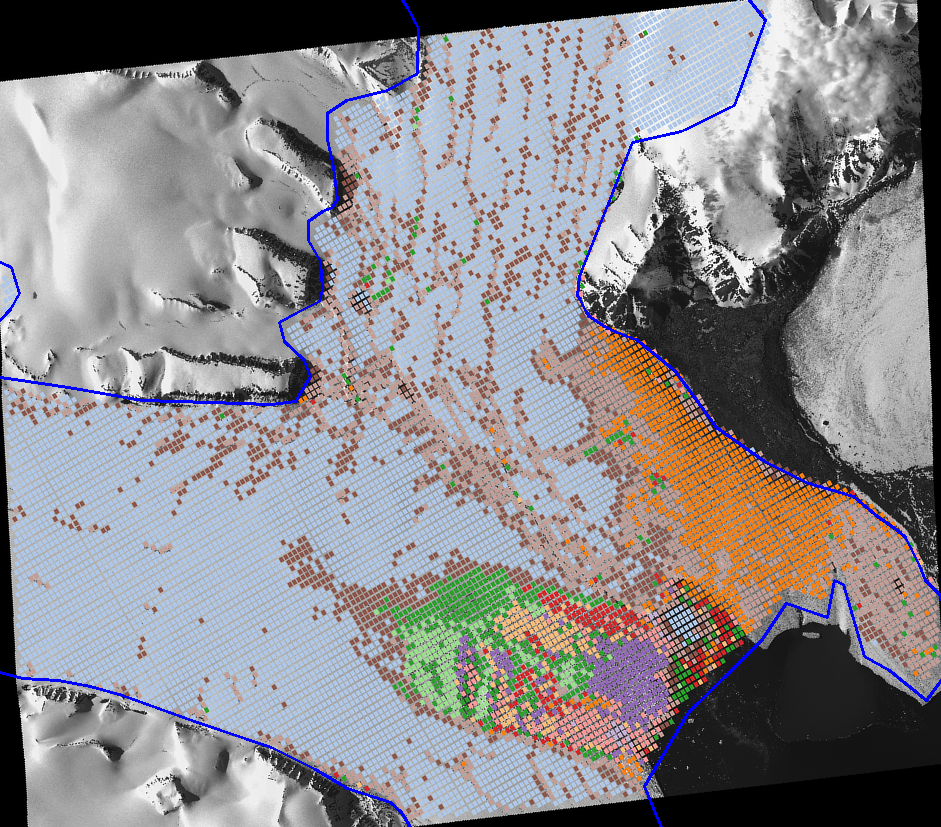
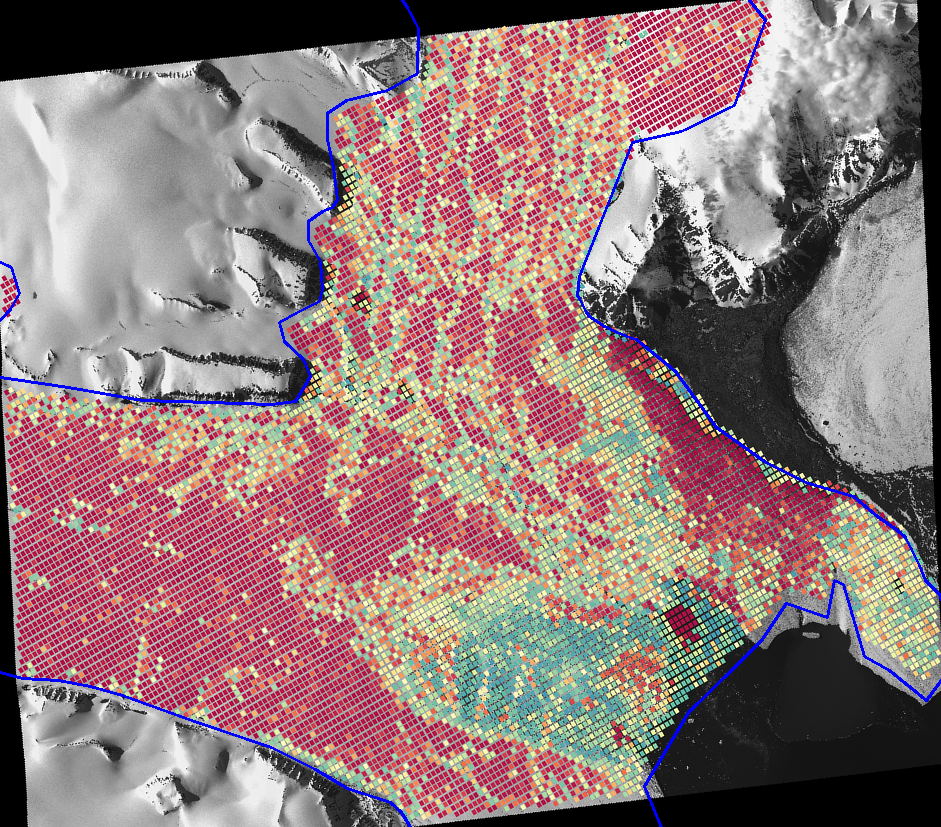

## Other Forms of Visualization

Another way to analyze the results from training is by creating accuraccy histograms or confidence matrices. The program `Hist.py` will create a histogram comparing the accuracy of two labeled datasets. `Hist.py` uses the training indeces defined by `triain_indices` in the Config file to only use the split images that were used for validation to avoid biases from the images used in training. First set the `train_npy` and `valid_npy` variables in the Config file to the first labeled training file you wish to use and the validation file respectivly.  The user does need to edit this file in order to run it properly, first the need to find the following line of code:
```
model_labels_path1 =
```
Set this variable equal to the directory for the second labeled training file you wish to use. Next go to the end of the code and modify the labels of the plots under the `Plot bars` section and run the `Hist.py` with the config file as an argument like:
```
python3 Hist.py Config/mlp_negri_legacy/mlp_test_negri.config
```
An example of what this histogram may look like can be seen below:

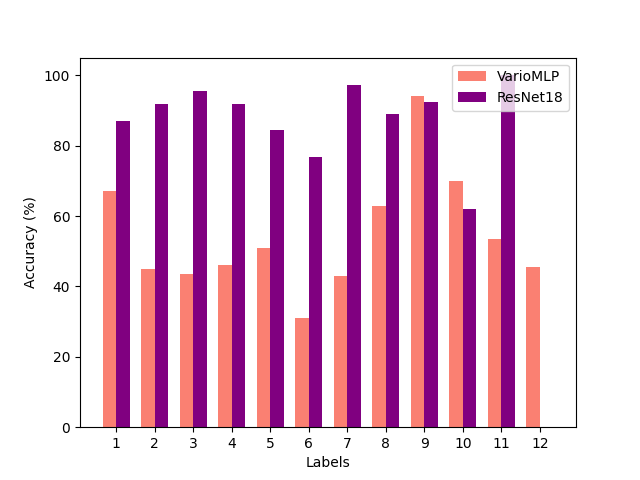

Another way to visualize the results from training is through the `confMatrix.py` program. Running this creates a confidence matrix: a figure plotting what the split images were labeled as and what they were labeled as during testing for every image and class. The diagonal from top left to bottom right shows how many images in each class were labeled correctly. To run this program, change `train_npy` and `valid_npy` in the Config file in the same was as for `Hist.py` and run `confMatrix.py` with the Config file as an argument like:
```
python3 confMatrix.py Config/mlp_negri_legacy/mlp_test_negri.config
```
A confidence matrix created in GEOCLASS can be seen below:

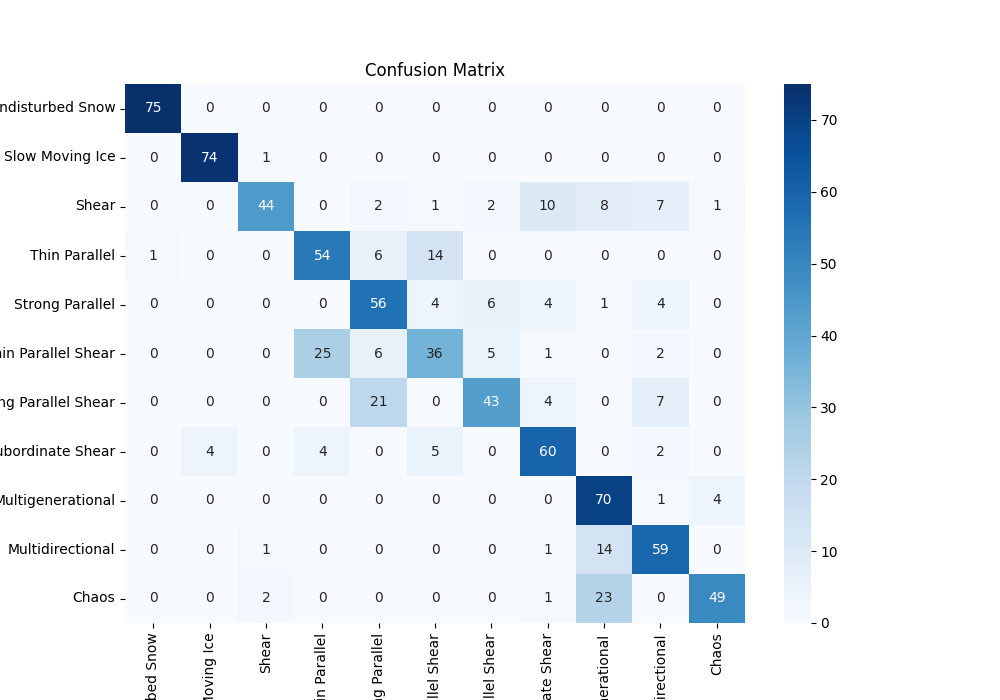

# Saving and Using Predicted Datasets

ML networks often require datasets on orders of maginitude unachievable through hand labeling techniques. The need for large labeled datasets increases as the networks complexity and depth increases and while hand labeled datasets may work for smaller datasets, the lack of training data causes ML networks to generalize poorly resluting in a decrease of accuracy as the size of the dataset being labeled increases. In order to work around this ML issue GEOCLASS can be run in a cyclical fashion to increase the size of the labeled dataset used for training. New features to the GEOCLASS CI were added to allow for the customization of datasets created through the testing.

## Saving Datasets in the GUI
In order to save these customized datasets, the user will need to change some variables found in the Config file. The `save_all_pred` and `equal_dataset` variables in the Config file can be modified to help customize the dataset. When `save_all_pred` is set to true it will save every single split image in the dataset, when false only the split images from the currently selected WV file will be saved. The other variable, `equal_dataset`, allows for the user to create datasets where there is an equal number of images in every class to prevent networks from developing a bias for classes with the most images. Due to the physicall proccesses that create the classes used for a crevasse based classification, some classes are much more prominent than others which could lead to a network overclassifying the more promentint classes, while completely missing the rarer classes. When set true, this variable will cause the number of images in every class to equal that of the smallest class, for the other classes, only the images with the highest confidence will be used, and this variable should be set to true if the user wishes to create a dataset that will be used for the training of other ML models. Once these variables have been initialized, run the GUI with the labeled file and config file as arguments in the same manner as how Split Image Explorer was run for the visualization of predicitions. In Section 6 of the Labeled GUI there is a button labeled `Save Confidence Predictions`, this saves the dataset as specified in the Config file for all split images with confidence's equal or greater than that selected through the confidence slider in Section 4 of the Labeled GUI. When this button is clicked, a file named as `confidence_predictions_{minimum-confidence}.npy` will be saved to a directory labeled `ConfidentPredictions`. During the saving of this dataset, information about the number of images per class and the total size of the dataset will be printed to the console as shown below:

![Screenshot from 2025-04-11 15-11-14.png](<attachment:Screenshot from 2025-04-11 15-11-14.png>)

Once the dataset has been saved, the user can then retrain their model with this larger dataset, ideally resulting in a better generalized model that can be used to create more accurate predictions on a new and larger dataset. This can be done several times and can allow the user to create and release large cyropsheric datasets, train deeper networks, and improve the accuracy of the ML models.
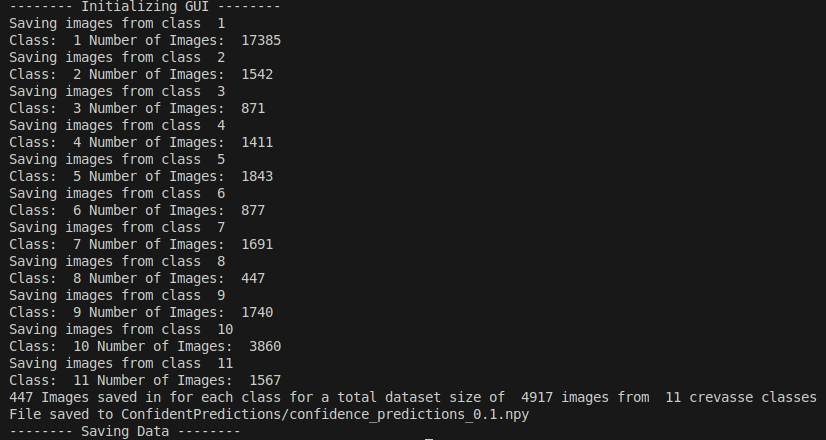